In [1]:
!pip install fastai==1.0.52

    100% |████████████████████████████████| 225kB 7.9MB/s ta 0:00:011
  Found existing installation: fastai 1.0.51
    Uninstalling fastai-1.0.51:
      Successfully uninstalled fastai-1.0.51
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'test', 'train.csv', 'sample_submission.csv']


In [3]:
from pathlib import Path
from fastai.vision import *
import torch
import random

In [4]:
PATH = Path('../input')
'''Setting seed for reproducibility'''
SEED = 2019

# python RNG
random.seed(SEED)

# pytorch RNGs
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# numpy RNG
np.random.seed(SEED)

In [5]:
batch_size = 96

In [6]:
tfms = get_transforms(flip_vert=True)

In [7]:
src = (ImageList.from_csv(csv_name='train.csv', path=PATH, folder='train/train')
            .split_by_rand_pct(0.1)
            .label_from_df(cols='has_cactus'))

In [8]:
data = (src.transform(tfms,size=128)
          .databunch(bs=batch_size)
           .normalize(imagenet_stats))

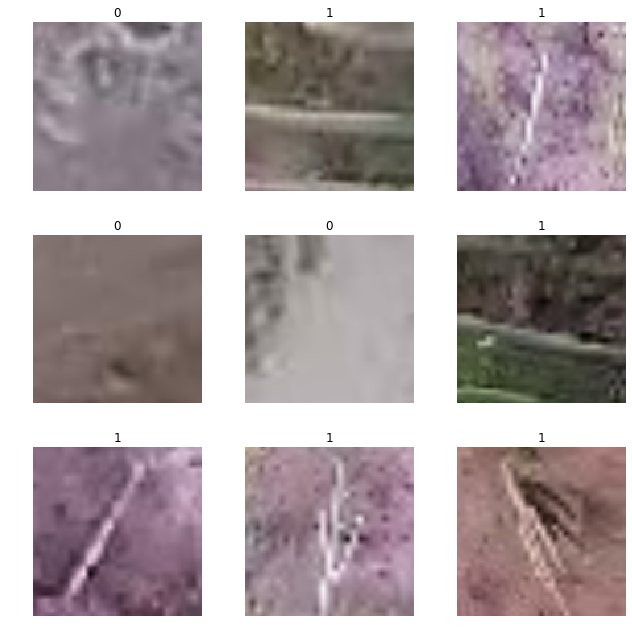

In [9]:
data.show_batch(rows=3, figsize=(9, 9))

In [10]:
data.classes, data.c

([0, 1], 2)

In [11]:
learn = cnn_learner(data, models.densenet161, metrics=accuracy, path='./')

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /tmp/.torch/models/densenet161-8d451a50.pth
115730790it [00:01, 75118139.99it/s]


In [12]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

In [13]:
lr = 3e-2
learn.fit_one_cycle(4,slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.047444,0.009008,0.996000,01:35
1,0.032372,0.066891,0.980571,01:17
2,0.009005,0.002220,0.999429,01:17
3,0.004443,0.002030,0.998857,01:18


In [14]:
# learn.save('stage-1-dense161')

In [15]:
# learn.unfreeze()

In [16]:
# learn.fit_one_cycle(5, 1e-6)

In [17]:
# learn.save('stage-2-dense161')

In [18]:
# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_top_losses(9, figsize=(7,6))

In [19]:
# interp.plot_confusion_matrix(figsize=(3, 3))

In [20]:
data = (src.transform(tfms, size=128)
        .add_test_folder('test/test')
        .databunch()
        .normalize(imagenet_stats))

In [21]:
learn.data = data

In [22]:
probs, _ = learn.get_preds(ds_type=DatasetType.Test)

In [23]:
ilst = data.test_ds.x

In [24]:
fnames = [item.name for item in ilst.items]; fnames[:10]

['9cdda32671cb192f096b20c91b46a150.jpg',
 'da498fc860c8b76ca925c4218c5f0373.jpg',
 '433052030eeb117e4bd8f6ce033c9da4.jpg',
 '4c76899a6e4b4a6cfdd2f28707fa8114.jpg',
 '9efa3e92c1475b3ce4b7e2e598fa2785.jpg',
 '873191a1575a6292ed92714bfc659b87.jpg',
 '8f99b87b7a652d68232fbd6379529368.jpg',
 '316e46903ee485aeecfd229973abcc71.jpg',
 'fc76ae520f30c6aba6dbfa8e82def89c.jpg',
 'ee3ddba5f04e0674db0d18a9dd3b8131.jpg']

In [25]:
test_df = pd.DataFrame({'id': fnames, 'has_cactus': probs.numpy()[:,0]}); test_df.head()

,id,has_cactus
0,9cdda32671cb192f096b20c91b46a150.jpg,0.000001
1,da498fc860c8b76ca925c4218c5f0373.jpg,0.000032
2,433052030eeb117e4bd8f6ce033c9da4.jpg,0.000002
3,4c76899a6e4b4a6cfdd2f28707fa8114.jpg,1.000000
4,9efa3e92c1475b3ce4b7e2e598fa2785.jpg,0.000001


In [26]:
test_df.to_csv('submission.csv', index=None)